# Introduction

This tutorial demonatrate the basic workflow of Tensorflow using simple linear model

# Imports

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix

/Users/mahipal/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Load Data

The MNIST data of handwritten digits will be downlodaed using below code, if not available in directory

In [9]:
from mnist import MNIST
data = MNIST(data_dir = "data/MNIST/")

In [10]:
print("Size of:")
print("- Training-set:\t\t{}".format(data.num_train))
print("- Validation-set:\t{}".format(data.num_val))
print("- Test-set:\t\t{}".format(data.num_test))

Size of:
- Training-set:		55000
- Validation-set:	5000
- Test-set:		10000


In [25]:
# The images are stored in 1-D arrays of this graph
img_size_flat = data.img_size_flat
#Tuple with height and width of images used to reshape arrays
img_shape = data.img_shape
#Number of classses, one class for each of 10 digits
num_classes = data.num_classes

In [12]:
print(img_size_flat)

784


In [13]:
print(img_shape)

(28, 28)


In [14]:
print(num_class)

10


# One-Hot Encoding
The output-data is loaded as both integer class-numbers and so-called One-Hot encoded arrays. This means the class-numbers have been converted from a single integer to a vector whose length equals the number of possible classes. All elements of the vector are zero except for the $i$'th element which is 1 and means the class is $i$. For example, the One-Hot encoded labels for the first 5 images in the test-set are:

In [15]:
data.y_test[0:5,:]

array([[0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]])

In [18]:
#classes of integers
data.y_test_cls[0:5]

array([7, 2, 1, 0, 4])

# Helper function for plotting the images
Function used to plot 9 images in a 3x3 grid, and writing the true and predicted classes below each image.

In [19]:
def plot_images(images, cls_true, cls_pred=None):
    assert len(images) == len(cls_true) == 9
    #create figure with 3x3 sub-plots
    fig, axes = plt.subplots(3,3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)
    
    for i, ax in enumerate(axes.flat):
        #plot image
        ax.imshow(images[i].reshape(img_shape), cmap='binary')
        #Show true and predicted classes.
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true[i])
        else:
            xlabel = "True: {0}, Pred: {1}".format(cls_true[i], cls_pred[i])
        
        ax.set_xlabel(xlabel)
        #Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    #Ensure the plot is shown correctly with mulptiple plots
    # in a single notebook cell
    plt.show()

PLot a few images to see if data is correct

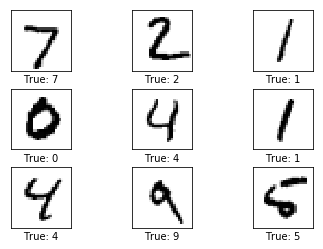

In [20]:
# get the first images from the test-set:
images = data.x_test[0:9]
#get the true classes for those images.
cls_true = data.y_test_cls[0:9]
#Plot the images and labels using our helper-function above
plot_images(images=images, cls_true=cls_true)

In [21]:
# Declaring placeholder variables
x = tf.placeholder(tf.float32, [None, img_size_flat])

In [26]:
#placeholder variable for the true labels associated 
#with the images that were input in the placeholder variable x
y_true = tf.placeholder(tf.float32, [None, num_classes])

In [30]:
#placeholder variable for 
#the true class of each image in the placeholder variable x.
y_true_cls = tf.placeholder(tf.int64,[None])

In [34]:
weights = tf.Variable(tf.zeros([img_size_flat, num_classes]))

In [36]:
biases = tf.Variable(tf.zeros([num_classes]))

# Model
This simple mathematical model multiplies the images in the placeholder variable x with the weights and then adds the biases.

In [37]:
logits = tf.matmul(x, weights) + biases

In [38]:
y_pred = tf.nn.softmax(logits)

In [39]:
y_pred_cls = tf.argmax(y_pred, axis=1)

# Cost function to be optimized

In [40]:
cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(logits=logits,labels=y_true)

In [41]:
cost = tf.reduce_mean(cross_entropy)

# Optimization method

In [97]:
optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.1).minimize(cost)

In [98]:
correct_prediction = tf.equal(y_pred_cls, y_true_cls)

In [99]:
accuracy = tf.reduce_mean(tf.cast(correct_prediction,tf.float32))

# Tensorflow Run
Create tensorflow session

In [46]:
session = tf.Session()

Initialize varibles

In [47]:
session.run(tf.global_variables_initializer())

# Helper-function to perform optimization iterations¶
There are 55.000 images in the training-set. It takes a long time to calculate the gradient of the model using all these images. We therefore use Stochastic Gradient Descent which only uses a small batch of images in each iteration of the optimizer.

In [48]:
batch_size = 100

In [100]:
def optimize(num_iterations):
    for i in range(num_iterations):
        #get a batch of training examples.
        #x_batch now holds a batch of images and
        #y_true_batch are the true lables for those images.
        x_batch, y_true_batch, _ = data.random_batch(batch_size=batch_size)
        
        # Put the batch in to dict with proper name
        # for placeholder variables in tensorflow graph
        # Note that the placeholder for y_true_cls is not set
        # becuae it is not used during trianing
        feed_dict_train = {x: x_batch, y_true: y_true_batch}
        
        # run the optimzeer using this batch of trininng data.
        # Tensorflow assigns the varibles in feed_dict_train
        # to the palceholder varibales and then runs the optimzer
        session.run(optimizer,feed_dict=feed_dict_train)
        

# Helper function to show the performance

In [51]:
feed_dict_test = {x: data.x_test, y_true: data.y_test,
                 y_true_cls:data.y_test_cls}

In [58]:
def print_accuracy():
    # use tensorflow to compute the accuracy
    acc = session.run(accuracy, feed_dict= feed_dict_test)
    #print accuracy
    print("Accuracy on test-set: {0:.1%}".format(acc))

Function for plotting and printing confusion matxi using scikit learn

In [83]:
def print_confusion_matrix():
    # Get the true classification for the test-set
    cls_true = data.y_test_cls
    # Get the predicted classification for the test-set
    cls_pred = session.run(y_pred_cls, feed_dict=feed_dict_test)
    # Get the confusion matrix using sklearn
    cm = confusion_matrix(y_true=cls_true, y_pred = cls_pred)
    #print the confusion matrix as text
    print(cm)
    # plot the confusion matrix as an image.
    plt.imshow(cm,interpolation='nearest',cmap=plt.cm.Blues)
    # Make various adjustments to the plot.
    plt.tight_layout()
    plt.colorbar()
    tick_marks = np.arange(num_classes)
    plt.xticks(tick_marks, range(num_classes))
    plt.yticks(tick_marks, range(num_classes))
    plt.xlabel("Predicted")
    plt.ylabel("True")
    # Ensure the plot is shown correctly with multiple plots
    # in a single notebook cell
    plt.show()

Function for plotting examples of images from the test-set that have been mis-classified

In [55]:
def plot_example_errors():
    # Use Tensorflow to get a list of boolean vlaues
    # whether each test-image has been correctly classified
    # and a list for the predicted class of each image
    correct, cls_pred = session.run([correct_prediction, y_pred_cls],
                                   feed_dict=feed_dict_test)
    # Negate the boolean array
    incorrect = (correct == False)
    # Get the images from the test-set that have incorrectly classified
    images = data.x_test[incorrect]
    # get the predicted classes for those images
    cls_pred = cls_pred[incorrect]
    #get the true classes for those images
    cls_true = data.y_test_cls[incorrect]
    # Plot the first 9 images.
    plot_images(images=images[0:9],
               cls_true=cls_true[0:9],
               cls_pred=cls_pred[0:9])
    

# Helper function to plot the model weights

In [56]:
def plot_weights():
    # Get the values for the weights from the TensorFlow variable.
    w = session.run(weights)
    
    # Get the lowest and highest values for the weights.
    # This is used to correct the colour intensity across
    # the images so they can be compared with each other.
    w_min = np.min(w)
    w_max = np.max(w)

    # Create figure with 3x4 sub-plots,
    # where the last 2 sub-plots are unused.
    fig, axes = plt.subplots(3, 4)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # Only use the weights for the first 10 sub-plots.
        if i<10:
            # Get the weights for the i'th digit and reshape it.
            # Note that w.shape == (img_size_flat, 10)
            image = w[:, i].reshape(img_shape)

            # Set the label for the sub-plot.
            ax.set_xlabel("Weights: {0}".format(i))

            # Plot the image.
            ax.imshow(image, vmin=w_min, vmax=w_max, cmap='seismic')

        # Remove ticks from each sub-plot.
        ax.set_xticks([])
        ax.set_yticks([])
        
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

# Performance before any optimization

In [101]:
print_accuracy()

Accuracy on test-set: 92.4%


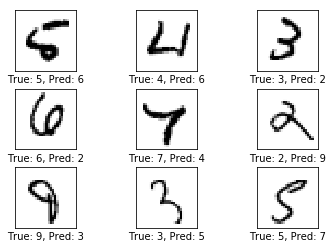

In [102]:
plot_example_errors()

Test performace after different optimization iterations

In [103]:
optimize(num_iterations=1000)

In [104]:
print_accuracy()

Accuracy on test-set: 92.4%


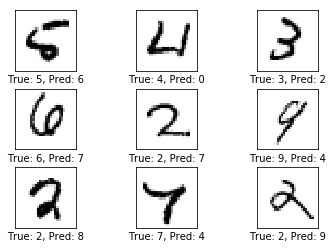

In [75]:
plot_example_errors()

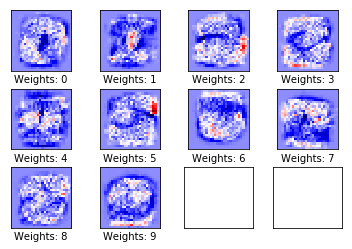

In [105]:
plot_weights()

[[ 958    0    1    3    0    8    6    3    1    0]
 [   0 1113    2    2    0    2    4    2   10    0]
 [   6   10  918   21    9    3   14   10   36    5]
 [   4    1   17  928    1   20    4   11   18    6]
 [   1    2    3    2  919    0   11    4    5   35]
 [   9    2    1   42    8  767   18   10   31    4]
 [  10    3    6    1    8   11  914    3    2    0]
 [   1    7   22    8    9    1    0  954    1   25]
 [   8    9    8   26    9   26   12   11  853   12]
 [   9    8    1   14   26    4    0   27    5  915]]


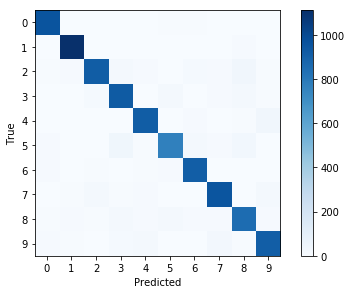

In [106]:
print_confusion_matrix()